In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotnine as p9
from plotnine import ggplot, aes

plt.style.use("ggplot")

output = "output/csv/"
input = "input/"
figures = "figures/"
uk = ["England", "Scotland", "Wales", "Northern Ireland"]

papers = pd.read_csv(f"{output}papers.csv")
students = pd.read_excel(f"{input}students.xlsx", sheet_name="Students")

to_exclude = [0, "0", np.nan, "nan", "None", "none", "", "Not Found", "Error"]

papers = papers[~papers["openalex_id"].isin(to_exclude)]

# Alumni Project Dashboard
## Summary
This dashboard contains information about the data collected and analysed
as part of the alumni project. I have grouped plots and summaries by theme
which you can access using the dropdowns (hopefully)!

## Data collection summary

Because part of the project is to collect and clean data, I'll start by demonstrating
the progress made in the data collection. 

### What is the structure of the data?

The data is stored in an Excel spreadsheet. There are three areas of data collection:
- Alumni information: each student is assigned a unique identifier. Their course, prior institutions and current location are listed.
- Alumni jobs: for each alumnus, this records (where known) each job they have held since leaving the DTC, including employer, title, start and end dates and location.
- Alumni publications: for each alumnus, this records all publications we've been able to find that they have published. This records title, authors, journal, year and DOI.

### A note on terminology
I use 'student' to refer to an individual prior to or suring their time at the DTC, after which they are alumni.

### Alumni info progress

The following plots show the progress made in data collection. The first plot shows the number of students for which we have collected alumni information, jobs and publications. The second plot shows the number of publications collected.

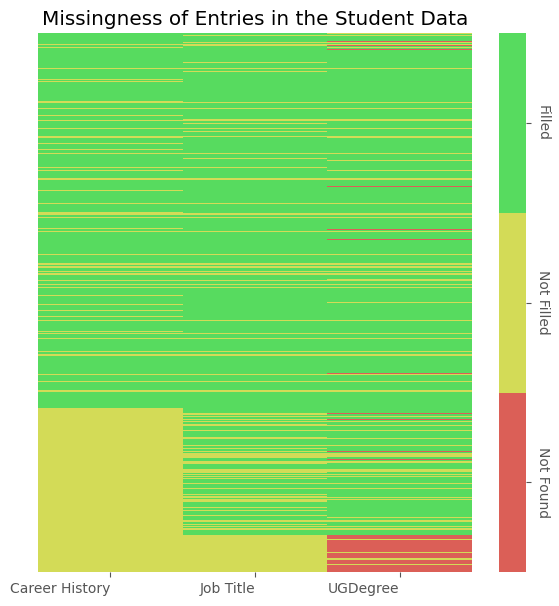

In [3]:
plt.figure(figsize=(7, 7))
# how many entries per year are filled?
cbar = sns.color_palette(sns.color_palette("hls"), 3)
missingness = students.notna().astype(str)
missingness[missingness == "True"] = "1"
missingness[missingness == "False"] = "0"
missingness[students == 0] = "-1"
missingness = missingness.astype(int)
missingness = missingness.loc[:, ["Career History", "Job Title", "UGDegree"]]
label_list = ["Not Found", "Not Filled", "Filled"]
hm = sns.heatmap(
    missingness, annot=False, yticklabels=False, xticklabels=1, cmap=cbar, linewidths=0
)
plt.xticks(plt.xticks()[0], rotation=0, horizontalalignment="right", fontsize=10)
colorbar = hm.collections[0].colorbar
r = colorbar.vmax - colorbar.vmin
colorbar.set_ticks(
    [colorbar.vmin + r / len(label_list) * (0.5 + i) for i in range(len(label_list))]
)
colorbar.set_ticklabels(label_list, size=10, rotation=270, verticalalignment="center")
plt.title("Missingness of Entries in the Student Data")
plt.savefig(f"{figures}missingness_plot.png")
plt.show()

I've chosen the columns shown because I believe they represent the progress overall:
- Career History: the most time-consuming to collect, as it  requires a lot of manual input. This was completed for starting years up to 2017.
- Job Title: relatively easy to collect. Indicates whether the person was found, and then whether they had listed a job title. Not all graduates have listed a job, and depending when they started, they may not have left yet.
- UG Degree: relatively easy to collect. Indicates whether the person was found, and then whether they had listed their degree. (PG not included here because  it was collected at the same time as UG, and not everyone has done both).

The categories are as follows:
- 'Filled' means that the data was collected and recorded
- 'Not Filled' means that the data was not collected
- 'Not Found' means that the data would have been collected, but it cannot be found (eg the student didn't list it, or it's not applicable)


## Student info: what happened pre-DTC?
### Where did they come from?

The following plots shows the distribution of where students were before
they came to the DTC. We can look at country and intitution of both the
undergraduate and postgraduate study, as well as whether students remained
where they started.

[]

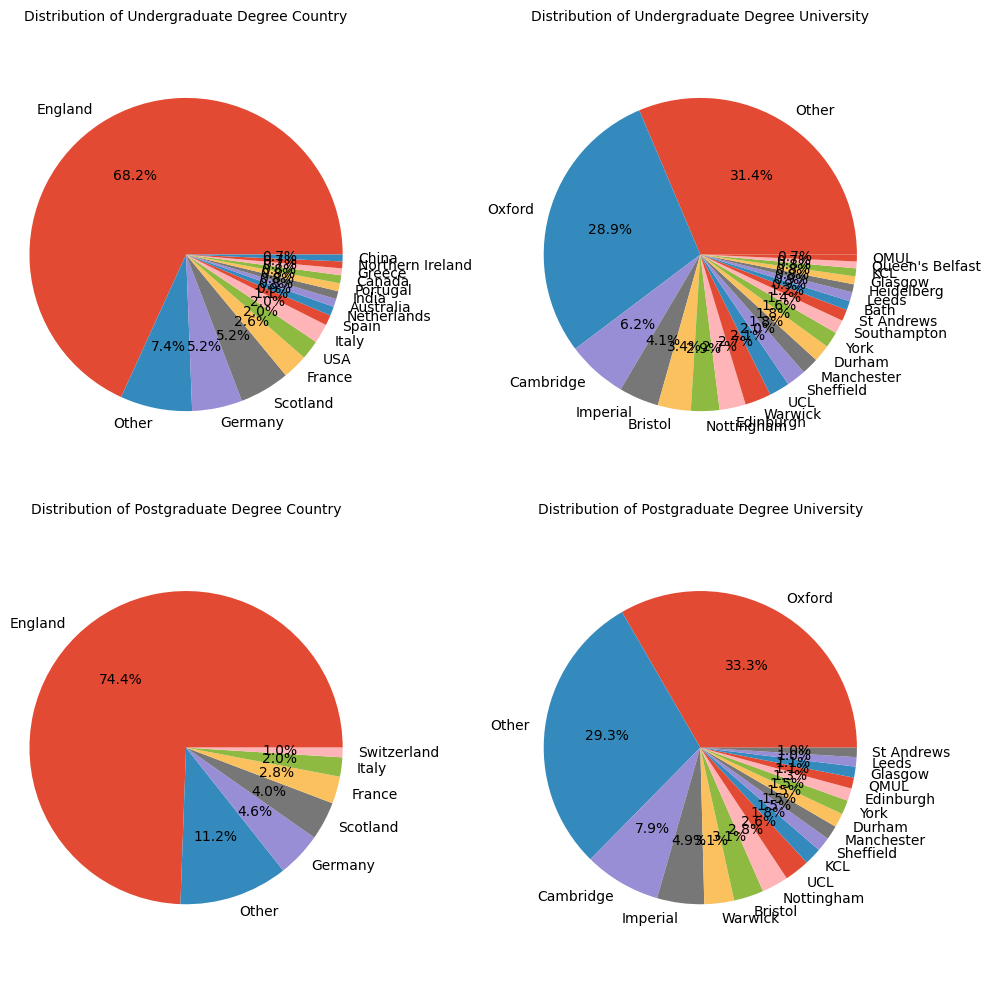

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
limit = 5

for i, tup in enumerate(zip(["UG", "PG"], ["Undergraduate", "Postgraduate"])):
    abbr = tup[0]
    full = tup[1]
    for j, col in enumerate(["Country", "University"]):
        ax = axs[i, j]
        counts = students[students[f"{abbr}{col}"] != 0]
        counts = counts[f"{abbr}{col}"].value_counts().reset_index()
        counts.columns = [col, "students"]
        other = counts[counts["students"] < limit]
        counts = counts[counts["students"] > limit]
        counts.loc[len(counts)] = ["Other", other["students"].sum()]
        counts = counts.sort_values("students", ascending=False)
        ax.pie(counts["students"], labels=counts[col], autopct="%1.1f%%")
        ax.axis("equal")
        ax.set_title(f"Distribution of {full} Degree {col}", size=10)
plt.tight_layout()
plt.savefig(f"{figures}degree_locs_pie.png")
plt.plot()

### What did they study?

The following plots shows the distribution of what students studied before
they came to the DTC. We can look at the subject of both the undergraduate
and postgraduate study. Subjects were grouped by 'Category' which is a
broad grouping of subjects. For example, 'Mathematics', 'Applied
Mathematics' and 'Statistics' etc. are grouped under 'Mathematics'.

[]

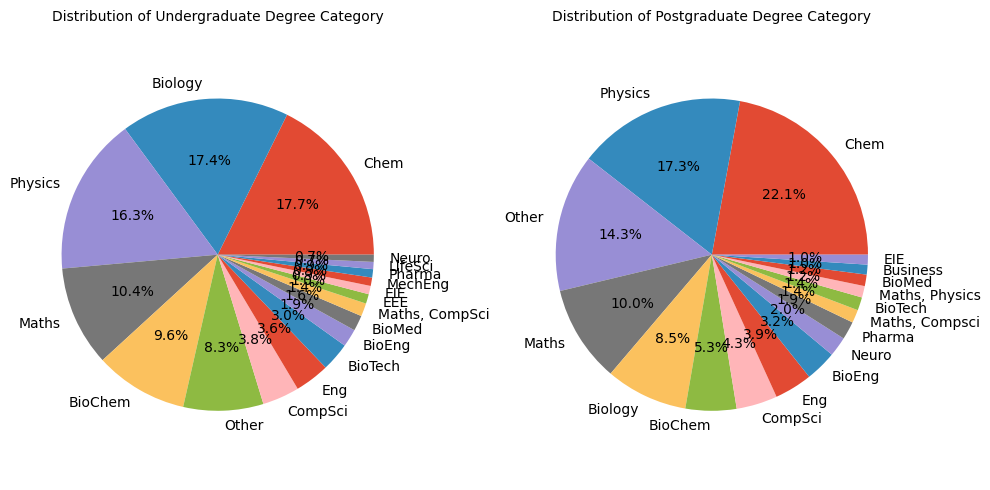

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
limit = 5

for i, tup in enumerate(zip(["UG", "PG"], ["Undergraduate", "Postgraduate"])):
    abbr = tup[0]
    full = tup[1]
    ax = axs[i]
    counts = students[students[f"{abbr}Category"] != 0]
    counts = counts[f"{abbr}Category"].value_counts().reset_index()
    counts.columns = ["category", "students"]
    other = counts[counts["students"] < limit]
    counts = counts[counts["students"] > limit]
    counts.loc[len(counts)] = ["Other", other["students"].sum()]
    counts = counts.sort_values("students", ascending=False)
    ax.pie(counts["students"], labels=counts["category"], autopct="%1.1f%%")
    ax.axis("equal")
    ax.set_title(f"Distribution of {full} Degree Category", size=10)
plt.tight_layout()
plt.savefig(f"{figures}degree_cats_pie.png")
plt.plot()


## Students by Course

How many students were there each year? What courses were they on?

<Figure size 700x700 with 0 Axes>

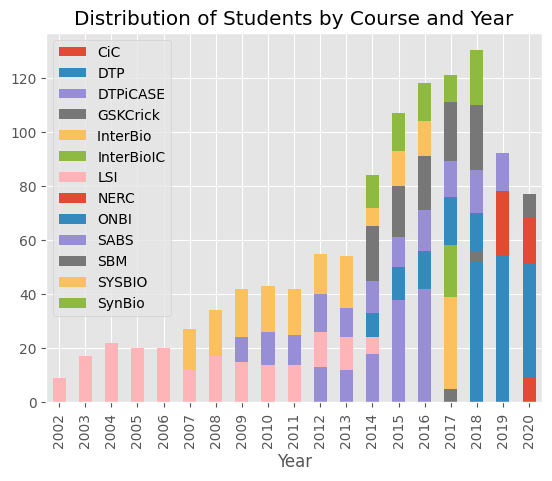

In [6]:
plt.figure(figsize=(7, 7))
# stacked bar chart of students by course and year
students["Year"] = students["Year"].astype(int)
students["Course"] = students["Course"].astype(str)
counts = students.groupby(["Year", "Course"]).size().unstack()
counts = counts.fillna(0)
counts.plot(kind="bar", stacked=True)
# make legend smaller
plt.legend(loc="upper left", bbox_to_anchor=(0, 1), ncol=1)
plt.title("Distribution of Students by Course and Year")
plt.savefig(f"{figures}course_year_bar.png")
plt.show()

## Graduate info: what are they doing now?
### Where are they now?

The following plots shows the distribution of where students are now. We
can look at country and intitution of both the undergraduate and
postgraduate study.

Firstly, on the top level, we can look at what continents graduates have
found themselves in.

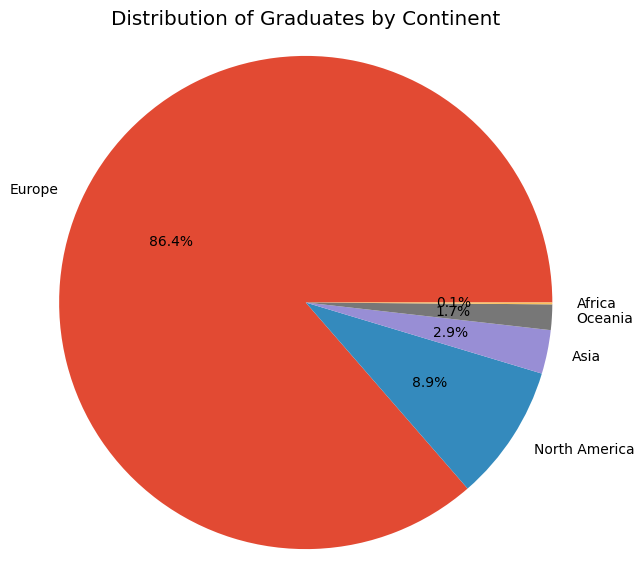

In [7]:
plt.figure(figsize=(7, 7))
# how many in each continent
counts = students["Continent"].value_counts().reset_index()
counts.columns = ["index", "Continent"]
plt.pie(counts["Continent"], labels=counts["index"], autopct="%1.1f%%")
plt.axis("equal")
plt.title("Distribution of Graduates by Continent")
plt.savefig(f"{figures}continent_pie.png")
plt.show()

The overwhelming majority are (perhaps predictably) in Europe, with North America far behind in second place. Let's break that down by country.

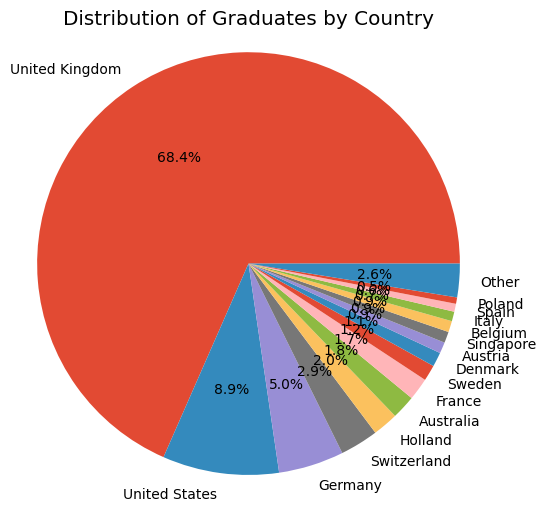

In [8]:
# graduates by country
plt.figure(figsize=(6, 6))
limit = 3
counts = students["Country"].value_counts().reset_index()
counts.columns = ["index", "Country"]
counts = counts.sort_values("Country", ascending=False)
other = counts[counts["Country"] < limit]
counts = counts[counts["Country"] > limit]
counts.loc[len(counts)] = ["Other", other["Country"].sum()]
plt.pie(counts["Country"], labels=counts["index"], autopct="%1.1f%%")
plt.axis("equal")
plt.title("Distribution of Graduates by Country")
plt.savefig(f"{figures}country_pie.png")
plt.show()

Unsurprisingly, the UK is the most popular destination. The pie chart also shows that the overwhelming majority of students in North America are in the US.

We can take a quick look at where graduates have gone outside of the UK in Europe.

Germany is the most popular destination, with Switzerland and Holland following behind.

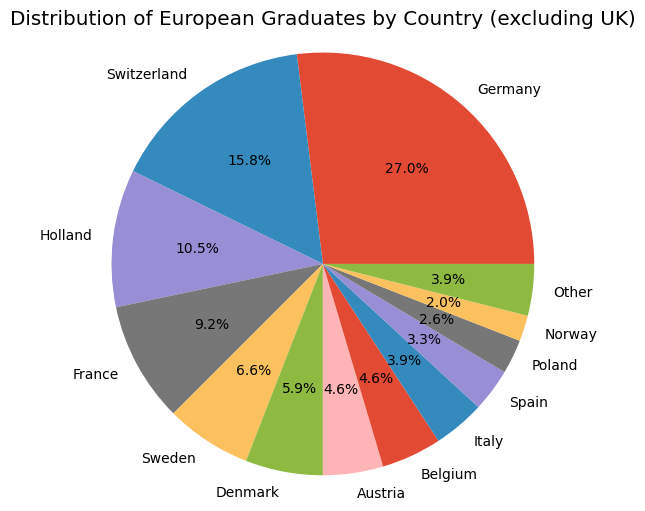

In [9]:
plt.figure(figsize=(6, 6))
# europe without the UK
limit = 2
counts = (
    students[students["Continent"] == "Europe"]["Country"].value_counts().reset_index()
)
counts.columns = ["index", "Country"]
counts = counts.sort_values("Country", ascending=False)
counts = counts[counts["index"] != "United Kingdom"]
other = counts[counts["Country"] < limit]
counts = counts[counts["Country"] > limit]
counts.loc[len(counts)] = ["Other", other["Country"].sum()]
counts.columns = ["index", "Country"]
plt.pie(counts["Country"], labels=counts["index"], autopct="%1.1f%%")
plt.axis("equal")
plt.title("Distribution of European Graduates by Country (excluding UK)")
plt.savefig(f"{figures}europe_nouk_country_pie.png")
plt.show()

Finally, we can look at where graduates have gone in the UK.

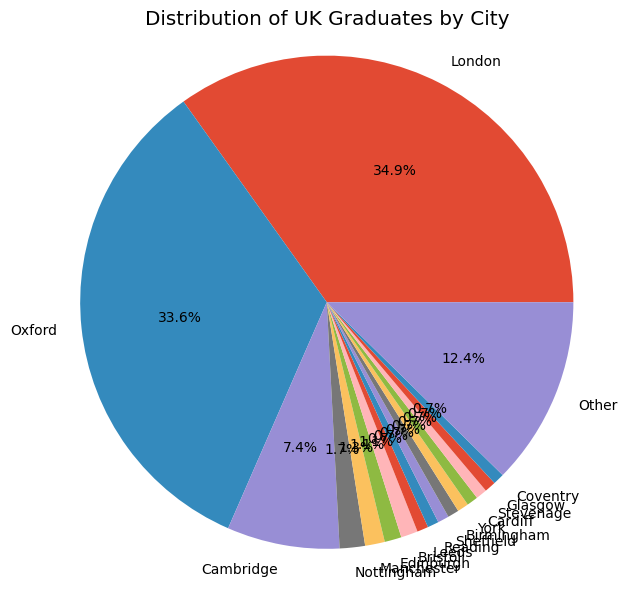

In [10]:
plt.figure(figsize=(7, 7))
# if UK, where are they?
limit = 3
counts = (
    students[students["Country"] == "United Kingdom"]["City"]
    .value_counts()
    .reset_index()
)
counts.columns = ["index", "City"]
counts = counts.sort_values("City", ascending=False)
other = counts[counts["City"] < limit]
counts = counts[counts["City"] > limit]
counts.loc[len(counts)] = ["Other", other["City"].sum()]
plt.pie(counts["City"], labels=counts["index"], autopct="%1.1f%%")
plt.axis("equal")
plt.title("Distribution of UK Graduates by City")
plt.savefig(f"{figures}uk_city_pie.png")
plt.show()


We can also look at whether graduates remained in the same country as that which they studied in prior to the DTC.
Additionally, did people stay in Oxford specifically? That is, if they studied in Oxford prior to the DTC, did they stay in Oxford? If they didn't, did they remain there after leaving the DTC?

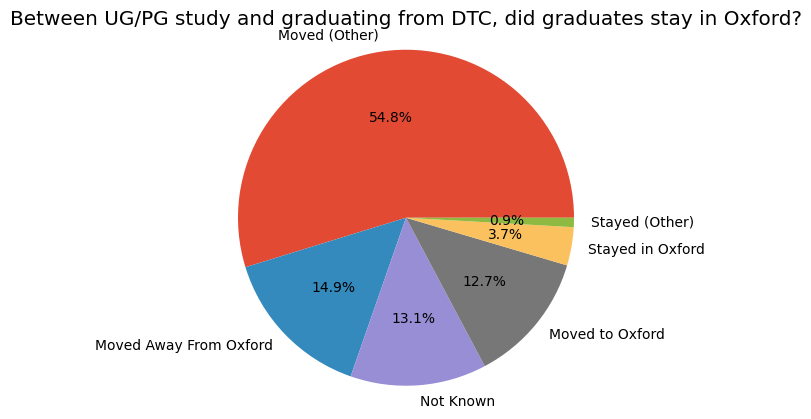

In [11]:
# Between UG/PG study and graduating from DTC, did graduates stay in Oxford?
counts = students.loc[:, ["PGUniversity", "City"]]
counts["last_known"] = counts["PGUniversity"].copy()
counts.loc[counts["last_known"].isna(), "last_known"] = students["UGUniversity"]
counts["place"] = None
counts.loc[counts["last_known"] == counts["City"], "place"] = "Stayed (Other)"
counts.loc[counts["last_known"] != counts["City"], "place"] = "Moved (Other)"
counts.loc[(counts["last_known"].isna()) & (counts["City"].isna()), "place"] = (
    "Not Known"
)
counts.loc[
    (counts["last_known"] == "Oxford") & (counts["City"] == "Oxford"), "place"
] = "Stayed in Oxford"
counts.loc[
    (counts["last_known"] != "Oxford") & (counts["City"] == "Oxford"), "place"
] = "Moved to Oxford"
counts.loc[
    (counts["last_known"] == "Oxford") & (counts["City"] != "Oxford"), "place"
] = "Moved Away From Oxford"
counts = counts["place"].value_counts().reset_index()
counts.columns = ["index", "place"]
plt.pie(counts["place"], labels=counts["index"], autopct="%1.1f%%")
plt.axis("equal")
plt.title("Between UG/PG study and graduating from DTC, did graduates stay in Oxford?")
plt.savefig(f"{figures}oxford_change_pie.png")
plt.show()

### What are they doing?
The following plot shows the distribution of graduates' current sector.

Most graduates are in the 'Academic' sector, with 'Research' and 'Pharma' following behind.

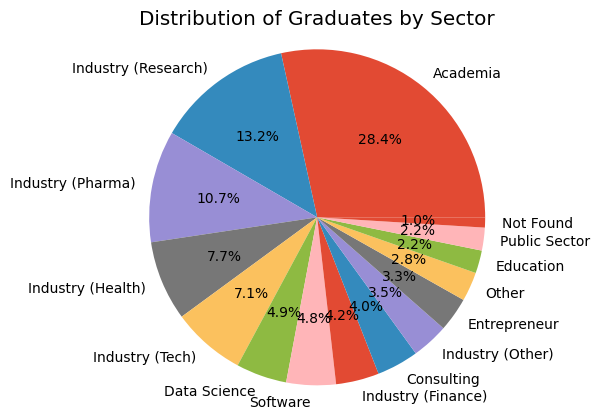

In [12]:
# graduates by sector
counts = students["Sector"].value_counts().reset_index()
counts.columns = ["index", "Sector"]
plt.pie(counts["Sector"], labels=counts["index"], autopct="%1.1f%%")
plt.axis("equal")
plt.title("Distribution of Graduates by Sector")
plt.savefig(f"{figures}sector_pie.png")
plt.show()

## Papers and publications
### Graduates' publications since starting with the DTC

A large proportion of the publication history was collected prior to my joining, using (at least mostly, I presume) methodology as outlined by Hector in his onboarding. This entailed looking up the graduate's name on Scopus and manually exporting their publication history as a spreadsheet which was then manually appended onto the master spreadsheet.

This has the advantage of accuracy (see discussion of manual LinkedIn scraping) but is time consuming, so I have opted to use an API instead. I have used [OpenAlex](https://openalex.org/): this is open source (unlike alternatives such as [SemanticScholar](https://www.semanticscholar.org/), who have not responded to my request for a key, and Elsevier's own proprietary API) and free (another win over Elsevier).

Methodology:
1. API search for each name in the alumni database. Retrieve the corresponding ORCID for the closest match, as well as said closest match's listed name.
2. Using these ORCIDs, perform an API search to find the corresponding OpenAlex 'author object' and its associated papers.
3. Where the name listed in the alumni database doesn't match the name corresponding to the ORCID found in the API search, manually check the ORCID/OpenAlex record for the person found. In some cases it's the same person under a different name; where this is NOT the case, exclude all papers with this ORCID.

I also performed random checks on the ORCIDs where there was a name match (ie those that were not auto-flagged as suspicious during step 3) to check that they are correct.

This code can be rerun any time, including with corrected ORCIDs need be.

To start with, we can look at how many papers each alumnus published. Of course this is a metric in which there will be a few extreme outlisers.

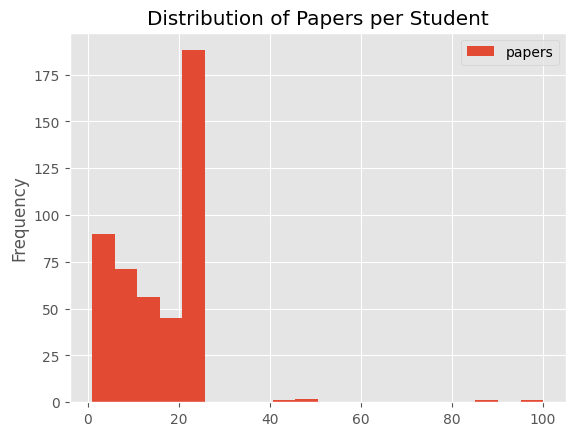

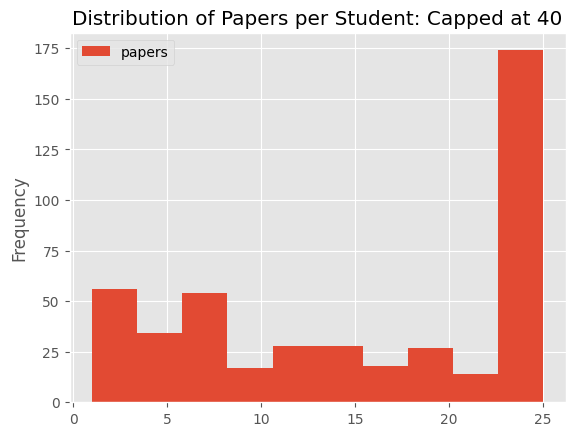

In [23]:
counts = papers["name_srcd"].value_counts().reset_index()
counts.columns = ["name_srcd", "papers"]
counts = counts.sort_values("papers", ascending=False)
counts["papers"] = counts["papers"].astype(float)
counts.plot(kind="hist", bins=20)
plt.title("Distribution of Papers per Student")
plt.savefig(f"{figures}papers_per_student_hist.png")
plt.show()

counts = papers["name_srcd"].value_counts().reset_index()
counts.columns = ["name_srcd", "papers"]
counts = counts.sort_values("papers", ascending=False)
counts["papers"] = counts["papers"].astype(float)
counts = counts[counts["papers"] <= 40]
counts.plot(kind="hist", bins=10)
plt.title("Distribution of Papers per Student: Capped at 40")
plt.savefig(f"{figures}papers_per_student_hist.png")
plt.show()

# citations_hist = (
#     ggplot(papers, aes(x="citation_count"))
#     + p9.geom_histogram(bins=20, fill="blue", color="black")
#     + p9.labs(title="Distribution of Citations per Paper")
# )
# citations_hist.save(f"{figures}citations_hist.png")
# citations_hist.draw()

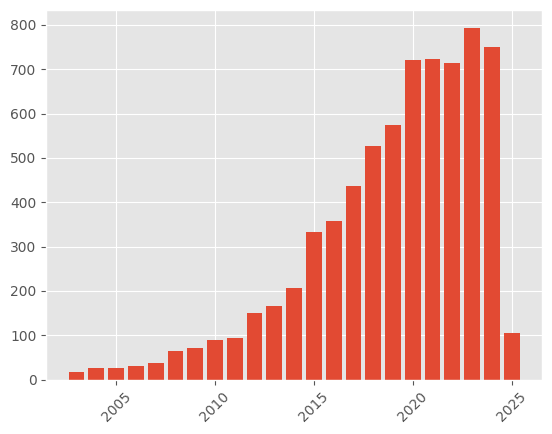

In [16]:
# bar chart of publication year
papers["years"] = papers["years"].astype(float)
# papers['years'] = papers['years'].astype(int)
papers_per_year = papers[papers["years"] > 2002]["years"].value_counts().reset_index()
papers_per_year.columns = ["years", "papers"]
papers_per_year = papers_per_year.sort_values("years")
plt.bar(papers_per_year["years"], papers_per_year["papers"])
# andgle the x-axis labels
plt.xticks(rotation=45)
plt.savefig(f"{figures}papers_per_year.png")
plt.show()

/Users/ioanaduta/Documents/alumni_project/venv/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/ioanaduta/Documents/alumni_project/venv/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: figures/citations_hist.png


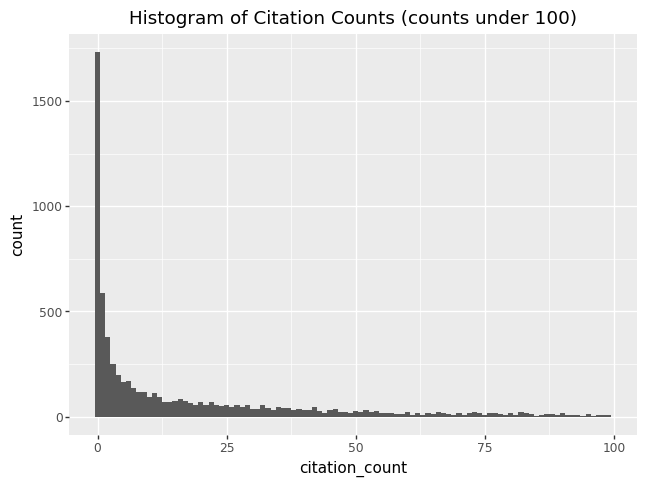

In [19]:
# histogram of citation count
papers["citation_count"] = papers["citation_count"].astype(float)
citation_counts = papers[papers["citation_count"] < 100]
# .value_counts().reset_index()
citation_histogram = (
    ggplot(citation_counts, aes("citation_count"))
    + p9.geom_histogram(binwidth=1)
    + p9.labels.ggtitle("Histogram of Citation Counts (counts under 100)")
    # + p9.scale_x_log10()
)
citation_histogram.save(f"{figures}citations_hist.png")
citation_histogram.draw()